# Entrenamiento del modelo

Una vez que tenemos nuestro conjunto de datos listo para ser utilizado para entrenar un modelo, podemos utilizar SageMaker para en esta ocasión crear un Job de entrenamiento. Básicamente utilizaremos la misma lógica del Jupyter Notebook descargado en la Introducción , es decir, entrenaremos tres distintos modelos utilizando los algoritmos del **Framework Scikit-learn: Gradient Boosting, Extra Trees y Random Forest**

### Como funcionan los Jobs de entrenamiento en SageMaker

![architecture](img/sagemaker-architecture-training-2.png)

Para entrenar un modelo en **Amazon SageMaker**, se debe crear un job de entrenamiento con la siguiente información:

*   La URL del _bucket_ de **Amazon S3** en dónde se encuentran los datos que serán utilizados para el entrenamiento
*   Los recursos de cómputo que queremos que **Amazon SageMaker** utilice para el entrenamiento del modelo. Los recursos de cómputo son instancias para Machine Learning administradas por **Amazon SageMaker**
*   La URL del bucket de **Amazon S3** en el cual queremos que se guarde el resultado del proceso de entrenamiento
*   La ruta de **Amazon Elastic Container Registry** en dónde el código de entrenamiento está almacenado. Para conocer más acerca de las rutas de los algoritmos incluidos en **Amazon SageMaker** consultar la [documentación](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html)

Existen las siguientes alternativas para entrenar un modelo utilizando **Amazon SageMaker**:

*   **Utilizar un algoritmo incluido en Amazon SageMaker** - si alguno de estos cubre tus necesidades, basta con proporcionarle los datos e hiperpárametros que este require. Para obtener una lista de los algoritmos incluidos consultar la [documentación](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html)
    
*   **Utilizar tu propio código de entrenamiento con algún framework soportado por Amazon SageMaker** - los frameworks soportados son: TensorFlow, Pytorch, MXNet, Chainer, Scikit-learn y la biblioteca XGBoost
    
*   **Utilizar tu propio algoritmo** - colocando tu código en una imagen **Docker** con todas las dependencias necesarias. Para mayor información consultar la [documentación](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms.html)
    
*   **Utilizar algún algoritmo mediante una suscripción a través de AWS Marketplace** - para mayor información acerca de como funcionan de estas suscripciones consultar la [documentación](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-mkt-find-subscribe.html)
    

En este taller utilizaremos la **tercer opción creando nuestro propio contenedor** con todas las dependencias necesarias para poder ejecutar el código proporcionado en el Jupyter Notebook descargado en la sección Introducción

Una vez creado el proceso de entrenamiento, **Amazon SageMaker** lanza las instancias de cómputo para Machine Learning especificadas y utiliza el código de entrenamiento y dataset de entrenamiento para entrenar el modelo. Al final guarda los artefactos del modelo resultante en el _bucket_ de **Amazon S3** especificado.

In [32]:
import os
import datetime
import sagemaker
import sagemaker_utils
import numpy as np
import matplotlib.pyplot as plt
from time import gmtime, strftime
from sklearn.metrics import confusion_matrix
from sagemaker import Session, get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter, CategoricalParameter
from sagemaker.inputs import TrainingInput, CreateModelInput, TransformInput
from sagemaker.workflow.steps import ProcessingStep, TrainingStep, CreateModelStep, TransformStep
from sagemaker.workflow.parameters import ParameterString, ParameterFloat
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.properties import PropertyFile
from sagemaker.model_metrics import MetricsSource, ModelMetrics
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet

sagemaker.__version__
session = Session()
#sagemaker_role = get_execution_role()

data_file = 'Data sets/churn.txt'

region = session.boto_region_name
account_id = session.account_id()
bucket = session.default_bucket()

prefix = 'churn-clf'
datasets_prefix = f'{prefix}/datasets'
processed_data_prefix = f'{prefix}/processed'
eval_prefix = f'{prefix}/eval'
transformed_data_prefix = f'{prefix}/transformed'
images_directory = f'{prefix}/images'
code_prefix = f'{prefix}/code'
model_prefix = f'{prefix}/models'

#processing
train_data_file = 'train_data.csv'
train_target_file = 'train_target.csv'
test_data_file = 'test_data.csv'
test_target_file = 'test_target.csv'
encoder_file = 'encoder.pkl'


Script para entrenamiento
=========================

En lugar de crear tres scripts distintos para cada algoritmo, crearemos uno sólo el cual a partir de los parámetros recibidos, entrenará el modelo con el algoritmo indicado. Utilizaremos la misma técnica de k-fold Cross-Validation utilizada en el Jupyter Notebook descargado de [Introducción](/sagemaker/intro/) .

Adicionalmente, este script nos servirá no solamente para el entrenamiento sino también para el despliegue posterior de nuestro modelo.

Creamos el archivo `train_and_serve.py` utilizando el siguiente código:

In [2]:
training_script_file = 'code/train_and_serve.py'

In [5]:
%%writefile $training_script_file
import argparse
import pickle
import os
import io
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Carga el modelo en memoria
def model_fn(model_dir):
    print('Cargando modelo: model_fn')
    clf = read_pkl(os.path.join(model_dir, "model.pkl"))
    return clf

# Deserealiza el body de la petición para poder generar las predicciones
def input_fn(request_body, request_content_type):

    if request_content_type == 'application/json':
        input_data = json.loads(request_body)
        input_data = pd.DataFrame.from_dict(input_data)
        # TODO: Es importante asegurarse de que las columnas se encuentran en el orden adecuado
        return input_data
        
    elif request_content_type == 'text/csv':      
        input_data = io.StringIO(request_body)        
        return pd.read_csv(input_data, header=None)
    else:
        raise ValueError("El endpoint del modelo solamente soporta Content-Types: 'application/json' o 'text/csv' como entrada")
                
# Genera la predicción sobre el objeto deserializado, con el modelo previamente cargado en memoria
def predict_fn(input_data, model):
    predict_proba = getattr(model, 'predict_proba', None)
    if callable(predict_proba):
        return predict_proba(input_data)[:, 1]
    else:
        return model.predict(input_data)

# Serializa el resultado de la predicción al correspondiente content type deseado
def output_fn(predictions, response_content_type):
    if response_content_type == 'application/json':        
        return json.dumps(predictions.tolist())
    elif response_content_type == 'text/csv':
        predictions_response = io.StringIO()
        np.savetxt(predictions_response, predictions, delimiter=',')
        return predictions_response.getvalue()
    else:
        raise ValueError("El endpoint del modelo solamente soporta Content-Types: 'application/json' o 'text/csv' como respuesta")        
        
def read_pkl(file):
    with open(file, 'rb') as f:
        return pickle.load(f)
    
def to_pkl(data, file):
    with open(file, 'wb') as f:
        pickle.dump(data, f)

def random_forest(**hyperparameters):
    return RandomForestClassifier(n_jobs=-1, 
                                  min_samples_split=hyperparameters['min_samples_split'],
                                  n_estimators=hyperparameters['n_estimators'],
                                  max_depth=hyperparameters['max_depth'],
                                  max_features=hyperparameters['max_features'])

def gradient_boosting(**hyperparameters):
    return GradientBoostingClassifier(learning_rate=hyperparameters['learning_rate'],
                                      min_samples_split=hyperparameters['min_samples_split'],
                                      n_estimators=hyperparameters['n_estimators'],
                                      max_depth=hyperparameters['max_depth'],
                                      max_features=hyperparameters['max_features'])

def extra_trees(**hyperparameters):
    return ExtraTreesClassifier(n_jobs=-1, 
                                min_samples_split=hyperparameters['min_samples_split'],
                                n_estimators=hyperparameters['n_estimators'],
                                max_depth=hyperparameters['max_depth'],
                                max_features=hyperparameters['max_features'])

def invalid_algorithm(**hyperparameters):
    raise Exception('Invalid Algorithm')
    
def algorithm_selector(algorithm, **hyperparameters):
    algorithms = {
        'RandomForest': random_forest,
        'GradientBoosting': gradient_boosting,
        'ExtraTrees': extra_trees
    }
    
    clf = algorithms.get(algorithm, invalid_algorithm)    
    return clf(**hyperparameters)


if __name__=='__main__':
    script_name = os.path.basename(__file__)
    print(f'INFO: {script_name}: Iniciando entrenamiento del modelo')
    
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--output-data-dir', type=str, default=os.environ.get('SM_OUTPUT_DATA_DIR'))
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train-data', type=str, default=os.environ.get('SM_CHANNEL_TRAIN_DATA'))
    parser.add_argument('--train-target', type=str, default=os.environ.get('SM_CHANNEL_TRAIN_TARGET'))
    
    parser.add_argument('--algorithm', type=str)
    parser.add_argument('--splits', type=int, default=10)
    parser.add_argument('--target-metric', type=str)
    
    parser.add_argument('--learning-rate', type=float)
    parser.add_argument('--min-samples-split', type=int)
    parser.add_argument('--n-estimators', type=int)
    parser.add_argument('--max-depth', type=int)
    parser.add_argument('--max-features', type=int)
    
            
    args, _ = parser.parse_known_args()
    
    print(f'INFO: {script_name}: Parametros recibidos: {args}')

    # Cargar datasets
    files = os.listdir(args.train_data)
    if len(files) == 1:
        train_data = pd.read_csv(os.path.join(args.train_data, files[0]))
    else:
        raise Exception('Mas de un archivo recibido para el channel Data')
    
    files = os.listdir(args.train_target)
    if len(files) == 1:
        train_target = pd.read_csv(os.path.join(args.train_target, files[0]))
        train_target = train_target['Churn'].tolist()
    else:
        raise Exception('Mas de un archivo recibido para el channel Target')
     
    clf = algorithm_selector(args.algorithm, 
                             learning_rate=args.learning_rate,
                             min_samples_split=args.min_samples_split,
                             n_estimators=args.n_estimators,
                             max_depth=args.max_depth,
                             max_features=args.max_features)
    
    skf = StratifiedKFold(n_splits=args.splits)    
    cv_scores = cross_validate(clf, train_data, train_target, cv=skf, scoring=args.target_metric, n_jobs=-1)
    print('{} = {}%'.format(args.target_metric, cv_scores['test_score'].mean().round(4)*100))
    
    # Entrenar el modelo
    clf.fit(train_data, train_target) 
    
    # Guardar modelo
    to_pkl(clf, os.path.join(args.model_dir, 'model.pkl'))

    print(f'INFO: {script_name}: Finalizando el entrenamiento del modelo')   



Writing code/train_and_serve.py


Empaquetamos el script en un archvio `.tar.gz` y lo subimos a un bucket de **Amazon S3** para poder utilizarlo en el job de entrenamiento y posteriormente para el despliegue del modelo.

In [6]:
training_script_tar_file = os.path.join('code',os.path.splitext(os.path.basename(training_script_file))[0] + '.tar.gz')

sagemaker_utils.create_tar_gz(training_script_file, training_script_tar_file)

training_script_path = sagemaker_utils.upload(training_script_tar_file, f's3://{bucket}/{code_prefix}')


Uploading: 100%|██████████| 2.06k/2.06k [00:01<00:00, 1.94kB/s]


##### Código utilizado durante el entrenamiento

El código utilizado para el entrenamiento es el encontrado en el cuerpo principal del programa, bajo `if __name__=='__main__'`.

Al igual que en el script utilizado para la preparación de los datos, vemos que se definen los siguientes parámetros, básicamente indicando las rutas de los archivos y los hiperparámetros de los algoritmos.

```python
    parser.add_argument('--output-data-dir', type=str, default=os.environ.get('SM_OUTPUT_DATA_DIR'))
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train-data', type=str, default=os.environ.get('SM_CHANNEL_TRAIN_DATA'))
    parser.add_argument('--train-target', type=str, default=os.environ.get('SM_CHANNEL_TRAIN_TARGET'))
    
    parser.add_argument('--algorithm', type=str)
    parser.add_argument('--splits', type=int, default=10)
    parser.add_argument('--target-metric', type=str)
    
    parser.add_argument('--learning-rate', type=float)
    parser.add_argument('--min-samples-split', type=int)
    parser.add_argument('--n-estimators', type=int)
    parser.add_argument('--max-depth', type=int)
    parser.add_argument('--max-features', type=int)
```   

Particularmente en los parámetros `--train-data` y `--train-target` encontramos las rutas de los archivos que necesitamos utilizar para el entrenamiento del modelo y los cargamos de la siguiente manera:

```python
    # Cargar datasets
    files = os.listdir(args.train_data)
    if len(files) == 1:
        train_data = pd.read_csv(os.path.join(args.train_data, files[0]))
    else:
        raise Exception('Mas de un archivo recibido para el channel Data')
    
    files = os.listdir(args.train_target)
    if len(files) == 1:
        train_target = pd.read_csv(os.path.join(args.train_target, files[0]))
        train_target = train_target['Churn'].tolist()
    else:
        raise Exception('Mas de un archivo recibido para el channel Target')
``` 

Cómo se describió al inicio, con la finalidad de tener un sólo script de entrenamiento para los tres algoritmos, se crearon las siguientes funciones para para instanciar el _Estimator_ correspondiente a cada algoritmo de acuerdo al parámetro recibido.

```python
    def random_forest(**hyperparameters):
        return RandomForestClassifier(n_jobs=-1, 
                                      min_samples_split=hyperparameters['min_samples_split'],
                                      n_estimators=hyperparameters['n_estimators'],
                                      max_depth=hyperparameters['max_depth'],
                                      max_features=hyperparameters['max_features'])
    
    def gradient_boosting(**hyperparameters):
        return GradientBoostingClassifier(learning_rate=hyperparameters['learning_rate'],
                                          min_samples_split=hyperparameters['min_samples_split'],
                                          n_estimators=hyperparameters['n_estimators'],
                                          max_depth=hyperparameters['max_depth'],
                                          max_features=hyperparameters['max_features'])
    
    def extra_trees(**hyperparameters):
        return ExtraTreesClassifier(n_jobs=-1, 
                                    min_samples_split=hyperparameters['min_samples_split'],
                                    n_estimators=hyperparameters['n_estimators'],
                                    max_depth=hyperparameters['max_depth'],
                                    max_features=hyperparameters['max_features'])
    
    def invalid_algorithm(**hyperparameters):
        raise Exception('Invalid Algorithm')
        
    def algorithm_selector(algorithm, **hyperparameters):
        algorithms = {
            'RandomForest': random_forest,
            'GradientBoosting': gradient_boosting,
            'ExtraTrees': extra_trees
        }
        
        clf = algorithms.get(algorithm, invalid_algorithm)    
        return clf(**hyperparameters)
```    

De esta forma utilizando la función `algorithm_selector` entrenamos el modelo

```python
    clf = algorithm_selector(args.algorithm, 
                                 learning_rate=args.learning_rate,
                                 min_samples_split=args.min_samples_split,
                                 n_estimators=args.n_estimators,
                                 max_depth=args.max_depth,
                                 max_features=args.max_features)
        
    skf = StratifiedKFold(n_splits=args.splits)    
    cv_scores = cross_validate(clf, train_data, train_target, cv=skf, scoring=args.target_metric, n_jobs=-1)
    print('{} = {}%'.format(args.target_metric, cv_scores['test_score'].mean().round(4)*100))
    
    # Entrenar el modelo
    clf.fit(train_data, train_target) 
```    

La línea de código `print('{} = {}%'.format(args.target_metric, cv_scores['test_score'].mean().round(4)*100))` nos permitirá posteriormente definir una expresión regular para monitorear el desempeño del entrenamiento de nuestros modelos.

Y una vez entrenado lo guardamos utilizando _Pickle_ para mas adelante poder cargarlo en memoria cuando realicemos el despligue del modelo

```python
    # Guardar modelo
        to_pkl(clf, os.path.join(args.model_dir, "model.pkl"))
```    

Con lo anterior es que implementamos una lógica similar, a la que encontramos en el Jupyter Notebook descargado, para entrenar los modelos utilizando los tres algoritmos **Random Forest**, **Gradient Boosting** y **Extra Trees**.

![Código de entrenamiento en Notebook](img/TrainingCode.png)

##### Código utilizado durante el despliegue

```python
    # Carga el modelo en memoria
    def model_fn(model_dir):
        clf = read_pkl(os.path.join(model_dir, "model.pkl"))
        return clf

    # Deserealiza el body de la petición para poder generar las predicciones
    def input_fn(request_body, request_content_type):
        print(f'INFO: input_fn: request_content_type: {request_content_type}')
        print(f'INFO: input_fn: request_body: {request_body}')
        if request_content_type == 'application/json':        
            return json.loads(request_body)
        elif request_content_type == 'text/csv':      
            data = io.StringIO(request_body)        
            return pd.read_csv(data)
        else:
            raise ValueError('El endpoint del modelo solamente soporta Content-Type="application/json" como input')
            
    # Genera la predicción sobre el objeto deserializado, con el modelo previamente cargado en memoria
    def predict_fn(input_data, model):
        predict_proba = getattr(model, 'predict_proba', None)
        if callable(predict_proba):
            return predict_proba(input_data)[:, 1]
        else:
            return model.predict(input_data)

    # Serializa el resultado de la predicción al correspondiente content type deseado
    def output_fn(prediction, response_content_type):
        print(f'INFO: output_fn: response_content_type: {response_content_type}')
        if response_content_type == 'application/json':        
            return json.dumps(prediction.tolist())
        elif response_content_type == 'text/csv':
            predictions_response = io.StringIO()
            np.savetxt(predictions_response, prediction, delimiter=',')
            return predictions_response.getvalue()
        else:
            raise ValueError('El endpoint del modelo solamente soporta Content-Type="application/json" como output') 
```   

*   La función `model_fn` tiene la lógica para cargar el modelo en memoria y se ejecuta solamente al iniciar por primera vez el contenedor, una vez hecho el despligue del modelo, lo cual se describe en el **capítulo 8**
*   Con cada petición al endpoint del modelo, una vez desplegado, se ejecutan las siguientes funciones en este respectivo orden:
    1.  `input_fn` la cual recibe los datos provenientes de la petición y se encarga de realizar la transformación que sea necesaria para poder posteriormente pasar los datos al modelo para generar la predicción
    2.  `predict_fn` se encarga de generar la predicción, recibiendo como entrada la salida de la función `input_fn`
    3.  `output_fn` una vez obtenida la predicción, esta función se encarga de realizar las transformaciones necesarias para devolver la respuesta al solicitante de la petición

Con esto estamos listos para crear un Job de entrenamiento en **Amazon SageMaker**.

Crear Training Job
==================

Para crear el Job de entrenamiento en **Amazon SageMaker** utilizamos la clase `CustomEstimator` (descargada con las dependencias de este laboratorio al inicio del Notebook) para crear un Estimator el cual permita integrar nuestro script `train_and_serve.py` con el contenedor Docker que previamente creamos para el entrenamiento de nuestros modelos.

También utilizaremos la expresión regular `recall = (\d+\.\d{1,2})?` para definir una métrica de desempeño de nuestro algoritmo, en este caso por tratarse de un problema de Churn, lo que buscamos es incrementar el Recall, esta métrica es calculada mediante el uso de k-Fold Cross-Validation. **Amazon SageMaker** aplica esta expresión regular a los mensajes de la salida estándar. Posteriormente mediante el uso de esta métrica podremos crear un Job de optimización de hiperparámetros.

Para ejecutar los procesos de entrenamiento lo haremos llamando el método `fit` del estimator previamente creado. Y lo haremos creando tres procesos de entrenamiento en paralelo, esta es una de las ventajas que nos da al entrenar modelos utilizando **Amazon SageMaker**, ya que no dependemos de la capacidad de cómputo de nuestras computadoras o dónde estemos ejecutando el Jupyter Notebook. En este caso los procesos de entrenamiento son ejecutados en infraestructura en AWS, orquestada y administrada por **Amazon SageMaker**.


**Esta ejecucion se debe hacer posterior a la generacion de las imagenes, para tener las img uris**  
La traemos de Sagemaker_pipelines previamente ejecutado

In [11]:
docker_images = {'Processing': {'libraries': {'pandas': '1.2.4',
   'numpy': '1.20.2',
   'scikit-learn': '0.24.2'},
  'build_id': 'churn-clf-processing-build-image:7e3a3c1e-4038-4a84-aae6-408606f73789',
  'image_uri': '829825986145.dkr.ecr.us-east-1.amazonaws.com/churn-clf-processing:latest'},
 'Training': {'libraries': {'pandas': '1.2.4',
   'numpy': '1.20.2',
   'scikit-learn': '0.24.2',
   'sagemaker-training': '3.9.2'},
  'build_id': 'churn-clf-training-build-image:acd0f05b-4dba-48d4-85ca-c06c2addfd4e',
  'image_uri': '829825986145.dkr.ecr.us-east-1.amazonaws.com/churn-clf-training:latest'},
 'Inference': {'libraries': {'pandas': '1.2.4',
   'numpy': '1.20.2',
   'scikit-learn': '0.24.2',
   'multi-model-server': '1.1.8',
   'sagemaker-inference': '1.5.11',
   'boto3': '1.21.43',
   'itsdangerous': '2.0.1'},
  'dependencies': [('serving', '/opt/ml/serving')],
  'others': ['RUN pip install -e /opt/ml/serving',
   'LABEL com.amazonaws.sagemaker.capabilities.multi-models=false',
   'LABEL com.amazonaws.sagemaker.capabilities.accept-bind-to-port=true'],
  'entrypoint': ['python', '/opt/ml/serving/custom_inference/serving.py'],
  'cmd': ['serve'],
  'build_id': 'churn-clf-inference-build-image:c096f995-2a79-4ea7-8364-0aa4afa43752',
  'image_uri': '829825986145.dkr.ecr.us-east-1.amazonaws.com/churn-clf-inference:latest'}}

sagemaker_role = "arn:aws:iam::829825986145:role/service-role/AmazonSageMaker-ExecutionRole-20220424T173630"

Previo a ejecutar nuestro Job de procesamiento, definimos las siguientes variables para mas adelante poder re-utilizarlas

In [ ]:
train_data_file = 'train_data.csv'
train_target_file = 'train_target.csv'
test_data_file = 'test_data.csv'
test_target_file = 'test_target.csv'
encoder_file = 'encoder.pkl'

In [14]:
estimators = {'GradientBoosting':{}, 'RandomForest':{}, 'ExtraTrees':{}}
metric_name = 'cross-val:recall'
metric_regex = 'recall = (\d+\.\d{1,2})?'

for algorithm in estimators:   
    estimators[algorithm] = Estimator(
        image_uri = docker_images['Training']['image_uri'],        
        entry_point = os.path.basename(training_script_file),
        source_dir = training_script_path,
        role = sagemaker_role,
        instance_count = 1,
        instance_type = 'ml.m5.xlarge',
        output_path = f's3://{bucket}/{model_prefix}',
        metric_definitions = [{'Name': metric_name, 'Regex': metric_regex}],
        volume_size = 5,
        max_run = 60*60*2, # dos horas
        hyperparameters={
            'algorithm':algorithm,
            'splits':5,
            'target-metric':'recall',
            'learning-rate': 0.1, 
            'min-samples-split': 3, 
            'n-estimators': 300,
            'max-depth': 25,
            'max-features':20})
    
    estimators[algorithm].fit(
        #{'train_data': sagemaker_utils.get_processor_output_path(processor, 'train_data'),
        #'train_target': sagemaker_utils.get_processor_output_path(processor, 'train_target')},
        {
            'train_data': f's3://{bucket}/{processed_data_prefix}/train_data',
            'train_target': f's3://{bucket}/{processed_data_prefix}/train_target'
        },
        wait=False)

Para esperar a que terminen de ejecutarse los procesos de entrenamiento en **Amazon SageMaker**, podemos utilizar el siguiente método:

In [15]:
sagemaker_utils.wait_for_training_jobs(estimators)

churn-clf-training-2022-05-01-18-42-29-648............................Completed!
churn-clf-training-2022-05-01-18-42-27-110............................Completed!
churn-clf-training-2022-05-01-18-42-29-648............................Completed!
churn-clf-training-2022-05-01-18-42-27-110............................Completed!
churn-clf-training-2022-05-01-18-42-29-648............................Completed!
churn-clf-training-2022-05-01-18-42-27-110............................Completed!
churn-clf-training-2022-05-01-18-42-29-648............................Completed!
churn-clf-training-2022-05-01-18-42-25-702............................Completed!
churn-clf-training-2022-05-01-18-42-27-110............................Completed!
churn-clf-training-2022-05-01-18-42-29-648............................Completed!
✅ Waiting for training jobs to finish


Y por último para obtener las métricas de desempeño de cada estimator, podemos iterar a través de estos.

Debemos ver un resultado como el siguiente:  
      
    **GradientBoosting: cross-val:recall = 72.41%**  
    **RandomForest: cross-val:recall = 71.03%**  
    **ExtraTrees: cross-val:recall = 60.91%**

In [16]:
for estimator in estimators:
        metrics = estimators[estimator].training_job_analytics.dataframe()
        test_recall = metrics[metrics['metric_name'] == metric_name]['value'].values[0]
        print(f'{estimator}: cross-val:recall = {test_recall}%')

GradientBoosting: cross-val:recall = 73.56%
RandomForest: cross-val:recall = 72.87%
ExtraTrees: cross-val:recall = 62.99%


### Capítulo 6

Optimización de hiperparámetros
===============================

### Objetivo

Amazon SageMaker nos ofrece la funcionalidad de optimización de hiperpárametros, ya sea utilizando una búsqueda aleatoria o un método bayesiano, en este caso vamos a utilizar el segundo método el cual permite entrenar un modelo de forma iterativa e ir identificando que combinación de hiperparámetros, nos permite minimizar o maximizar más la métrica objetivo.

Como funciona la optimización de hiperparámetros en SageMaker
=============================================================

**Amazon SageMaker** nos permite encontrar la mejor combinación de valores de los hiperparámetros de manera automática, mediante la ejecución de múltiples procesos de entrenamiento utilizando el rango de valores de los hiperparámetros que se especifique. Posteriormente selecciona los valores de hiperparámetros que resulten en el modelo con mejor desempeño, con base en una métrica objetivo previamente seleccionada.

Existen dos métodos que podemos utilizar para la búsqueda de los mejores valores de hiperparámetros:

*   **Random Search** – en la búsqueda aleatoria, **Amazon SageMaker** selecciona una combinación de valores de los rangos, especificados para los hiperparámetros, de forma aleatoria y posteriormente selecciona aquella combinación que haya dado el mejor desempeño. Debido a que la selección de la combinación de valores de los hiperparámetros no depende del resultado de los procesos de entrenamiento previos, es posible ejecutar el máximo número de procesos concurrentes en paralelo sin afectar el desempeño de la búsqueda
    
*   **Bayesian Search** – la búsqueda bayesiana trata la selección de los valores de los hiperparámetros como si se tratará de un problema de regresión. Dado un conjunto de hiperparámetros, **Amazon SageMaker** estima que combinación de estos tienen mayor probabilidad de obtener los mejores resultados y ejecuta procesos de entrenamiento para comprobar eso. Después de probar el primer conjunto de valores de hiperparámetros, vuelve a estimar la mejor combinación para la siguiente prueba. Continua de esa forma hasta alcanzar el número máximo de procesos de entrenamiento especificados al lanzar el proceso de optimización
    

En este taller utilizaremos el método de búsqueda bayesiana para la optmización de los valores de los hiperparámetros.

Para conocer más de la funcionalidad de optimización de hiperparámetros de **Amazon SageMaker** consultar la [documentación](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html) .

Crear proceso de optimización (Tuning Job)
==========================================

Gracias a que creamos tres estimators para el entrenamiento, ahora podemos crear tres procesos de optimización que se ejecuten en paralelo, para esto utilizamos la clase `HyperparameterTuner` y especificamos los rangos de valores para los hiperparámetros utilizando `ContinuousParameter`, `IntegerParameter` o `CategoricalParameter` dependiendo de si se trata de un valor continuo, discreto o categórico; respectivamente.



In [19]:
tuners = {}

total_jobs = 16
parallel_jobs = 2

tuners['GradientBoosting'] = HyperparameterTuner(
        estimator=estimators['GradientBoosting'],
        objective_metric_name=metric_name,
        objective_type='Maximize',
        hyperparameter_ranges={'learning-rate': ContinuousParameter(0.01, 0.1),
                                'min-samples-split': IntegerParameter(5, 15), 
                                'n-estimators': IntegerParameter(400, 800),
                                'max-depth': IntegerParameter(3, 10),
                                'max-features': IntegerParameter(15, 30)},
        metric_definitions=[{'Name': metric_name, 
                                'Regex': metric_regex}],
        max_jobs=total_jobs,
        max_parallel_jobs=parallel_jobs)

tuners['RandomForest'] = HyperparameterTuner(
        estimator=estimators['RandomForest'],
        objective_metric_name=metric_name,
        objective_type='Maximize',
        hyperparameter_ranges={'min-samples-split': IntegerParameter(3,10), 
                                'n-estimators': IntegerParameter(150,300),
                                'max-depth': IntegerParameter(20,35),
                                'max-features': IntegerParameter(15,30)},
        metric_definitions=[{'Name': metric_name, 
                                'Regex': metric_regex}],
        max_jobs=total_jobs,
        max_parallel_jobs=parallel_jobs)

tuners['ExtraTrees'] = HyperparameterTuner(
        estimator=estimators['ExtraTrees'],
        objective_metric_name=metric_name,
        objective_type='Maximize',
        hyperparameter_ranges={'min-samples-split': IntegerParameter(3,10), 
                                'n-estimators': IntegerParameter(150,350),
                                'max-depth': IntegerParameter(20,35),
                                'max-features': IntegerParameter(15,30)},
        metric_definitions=[{'Name': metric_name, 
                                'Regex': metric_regex}],
        max_jobs=total_jobs,
        max_parallel_jobs=parallel_jobs)
    



La variable `total_jobs` especifíca el número total de procesos de entrenamiento (combinaciones distintas de valores de hiperparámetros) a ejecutar y la variable `parallel_jobs` especifíca el número máximo de procesos a ejecutar en paralelo.

Para ejecutar cada uno de los procesos utilizamos el método `fit()` pasando como parámetros la ubicación de los datasets y mediante el parámetro `wait=False` es que le indicamos que ejecute el proceso de manera asíncrona (sin esperar a que cada uno de los procesos termine).

   

In [20]:
for tuner in tuners:
       tuners[tuner].fit(   #{
                            #'train_data': sagemaker_utils.get_processor_output_path(processor, 'train_data'),
                            #'train_target': sagemaker_utils.get_processor_output_path(processor, 'train_target')
                            #}, 
                            {
                            'train_data': f's3://{bucket}/{processed_data_prefix}/train_data',
                            'train_target': f's3://{bucket}/{processed_data_prefix}/train_target'
                            },
                     job_name= f'{prefix}-{tuner}-{strftime("%M-%S", gmtime())}',
                     wait=False)

Ahora que los tres procesos se ejecutan de forma asíncrona y paralela, mediante el siguiente método podemos esperar a que los tres procesos hayan terminado.

In [22]:
sagemaker_utils.wait_for_optmimization_jobs(tuners)

churn-clf-GradientBoosting-24-18......................................Completed!
churn-clf-RandomForest-24-20..........................................Completed!
churn-clf-ExtraTrees-24-22............................................Completed!
✅ Waiting for optimization jobs to finish


Mediante la invocación del método `describe()` podemos obtener el proceso de entrenamiento cuyo modelo resultante obtuvo el mejor desempeño, en este caso maximizando la métrica objetivo _Recall_. Posteriormente de los metadatos devueltos del mejor proceso de entrenamiento, podemos obtener los valores de los hiperparámetros así cómo el valor obtenido en la métrica objetivo.

In [23]:
hyperparameters = {}
for tuner in tuners:
    best_training_job = tuners[tuner].describe()['BestTrainingJob']
    objective_metric = best_training_job['FinalHyperParameterTuningJobObjectiveMetric']
    
    hyperparameters[tuner] = best_training_job['TunedHyperParameters']
    print(tuner)
    print(f"\thyper parameters: {hyperparameters[tuner]}")
    print(f"\t{objective_metric['MetricName']}: {objective_metric['Value']}\n")

GradientBoosting
	hyper parameters: {'learning-rate': '0.09756610928771621', 'max-depth': '6', 'max-features': '24', 'min-samples-split': '9', 'n-estimators': '503'}
	cross-val:recall: 76.08999633789062

RandomForest
	hyper parameters: {'max-depth': '27', 'max-features': '25', 'min-samples-split': '6', 'n-estimators': '230'}
	cross-val:recall: 74.94000244140625

ExtraTrees
	hyper parameters: {'max-depth': '33', 'max-features': '30', 'min-samples-split': '4', 'n-estimators': '159'}
	cross-val:recall: 71.02999877929688



Ahora que tenemos el mejor candidato (modelo con mejor desempeño) para cada uno de los tres algoritmos, podemos pasar a comparar el desempeño entre estos para seleccionar el mejor.

### Capítulo 7

Evaluación de desempeño
=======================

### Objetivo

Evaluar el desempeño de los modelos entrenados con SageMaker con la finalidad de seleccionar aquel que haya tenido el mejor desempeño, esto lo haremos nuevamente mediante el uso de un Processing Job de **Amazon SageMaker**.

Crear el script
===============

Al igual que cómo hicimos con la preparación de los datos, utilizaremos un _Processing Job_ de **Amazon SageMaker** pero en este caso para buscar el umbral de clasificación, es decir el modelo nos devuelve la probabilidad de que el cliente haga _Churn_ y lo que queremos en este caso es encontrar el valor a partir del cual clasificaremos como 1 (_churn_) o 0 (_no-churn_). Esto lo haremos buscando maximizar la métrica _Recall_ pero manteniendo un mínimo valor para la métrica _Precision_, que recibiremos como parámetro.

En el caso del Jupyter Notebook descargado podemos encontrar que esto se logra mediante la invocación de la siguiente función:  
![bms_finder](img/operating_point.png)

En la que básicamente se obtienen las predicciones del modelos y posteriormente mediante el uso de la función `precision_recall_curve()` del Framework **Scikit-learn** y después a través del método `argmax()` de la librería **numpy** obtenemos el punto en el cual la métrica _Recall_ se maximiza manteniendo el mínimo de la métrica _Precision_ buscado.

El programa que crearemos para el _Processing Job_ implementará una lógica similar y al final guardaremos los umbrales encontrados para cada modelo en un archivo separado por comas.


In [24]:
evaluate_models_script_file = 'code/evaluate_models.py'

In [27]:
%%writefile $evaluate_models_script_file
import argparse
import pickle
import os
import json
import tarfile
import pandas as pd
import numpy as np

from sklearn.metrics import precision_recall_curve

def load_model(file, model_file='model.pkl'):
    if file.endswith('tar.gz'):
        with tarfile.open(file, 'r:gz') as tar:
            for name in tar.getnames():
                if name == model_file:
                    f = tar.extractfile(name)
                    return pickle.load(f)
            return None
    elif file.endswith('pkl'):
        with open(file, 'rb') as f:
            return pickle.load(f)
    else:
        return None

if __name__=='__main__':
    script_name = os.path.basename(__file__)
    print(f'INFO: {script_name}: Iniciando la evaluación de los modelos')
    
    parser = argparse.ArgumentParser()
    parser.add_argument('--algos', type=str, required=True)
    parser.add_argument('--min-precision', type=float, required=True)    
    parser.add_argument('--test-data-file', type=str, required=True)
    parser.add_argument('--test-target-file', type=str, required=True)
    parser.add_argument('--thresholds-file', type=str, required=True)   
    parser.add_argument('--metrics-report-file', type=str, required=True)    
    
    args, _ = parser.parse_known_args()    
    
    print(f'INFO: {script_name}: Parámetros recibidos: {args}')
    
    input_path = '/opt/ml/processing/input'
    output_path = '/opt/ml/processing/output'
    
    # Cargar datasets
    test_target_path = os.path.join(input_path, 'target', args.test_target_file)     
    test_target = pd.read_csv(test_target_path)
    
    test_data_path = os.path.join(input_path, 'data', args.test_data_file)     
    test_data = pd.read_csv(test_data_path)
    
    # Umbrales de decision por algoritmo
    algo_metrics = {'Algorithm':[], 'Threshold':[], 'Precision':[], 'Recall':[]}
    
    metrics_report = {}
    
    algos = args.algos.split(',')
    for algo in algos:
        model_path = os.path.join(input_path, algo, 'model.tar.gz')         

        # Carga modelo en memoria
        print(f'Cargando modelo: {model_path}')
        clf = load_model(model_path)
        
        # Obtiene predicciones con dataset para pruebas
        predictions = clf.predict_proba(test_data)[:, 1]
        
        # Busca umbral de decision
        precision, recall, thresholds = precision_recall_curve(test_target, predictions)
        operating_point_idx = np.argmax(precision>=args.min_precision)
        
        algo_metrics['Threshold'].append(thresholds[operating_point_idx])
        algo_metrics['Precision'].append(precision[operating_point_idx])
        algo_metrics['Recall'].append(recall[operating_point_idx])
        algo_metrics['Algorithm'].append(algo)
        
        metrics_report[algo] = {
            'precision': {'value': precision[operating_point_idx], 'standard_deviation': 'NaN'},
            'recall': {'value': recall[operating_point_idx], 'standard_deviation': 'NaN'}}
            
    
    # Guardar Thresholds    
    metrics = pd.DataFrame(algo_metrics)
    print(f'INFO: {script_name}: Thresholds encontrados')
    print(metrics)
    metrics.to_csv(os.path.join(output_path, args.thresholds_file), index=False)    
    
    # Guardar reporte de metricas para cada modelo
    for algo in metrics_report:
        with open(os.path.join(output_path, f'{algo}_metrics.json'), 'w') as f:
            json.dump({'binary_classification_metrics':metrics_report[algo]},f)        

    
    print(f'INFO: {script_name}: Finalizando la evaluación de los modelos')

Overwriting code/evaluate_models.py


Subimos el script a un bucket de **Amazon S3** para poder utilizarlo con el _Processing Job_

In [29]:
evaluate_models_script_path = sagemaker_utils.upload(evaluate_models_script_file, f's3://{bucket}/{code_prefix}')

Uploading: 100%|██████████| 3.56k/3.56k [00:00<00:00, 4.01kB/s]


Ya que tenemos el script listo en S3, podemos pasar a crear el _Processing Job_.

Crear Processing Job
====================

Al igual que lo hicimos cuando creamos el _Processing Job_ para la preparación de los datos, en este caso creamos otro nuevamente utilizando la clase `Processor`.

In [30]:
evaluation_processor = Processor(
    image_uri=docker_images['Processing']['image_uri'],
    role=sagemaker_role,
    instance_count=1,
    instance_type='ml.m5.large',
    entrypoint=['python3',f'/opt/ml/processing/input/code/{os.path.basename(evaluate_models_script_file)}'],
    volume_size_in_gb=5,
    max_runtime_in_seconds=60*60*2)# dos horas 

Y ejecutamos el proceso con el método `run()`, proporcionando los siguientes parámetros:

*   `inputs` – rutas de las ubicaciones en **Amazon S3** de los archivos de entrada a ser utilizados, en este caso el dataset para pruebas, así como los archivos de predicciones de cada uno de los modelos y el programa Python a ejecutar dentro del contenedor
*   `outputs` – ruta para guardar el resultado del proceso, en este caso los umbrales para cada modelo
*   `arguments` – parámetros del proceso que son pasados cómo argumentos de la línea de comandos al programa Python que se ejecuta dentro del contenedor

In [33]:
thresholds_file = 'thresholds.csv'
metrics_report_file = 'metrics_report.json'

eval_parameters = {
    'inputs':[ProcessingInput(
                    input_name='code',
                    source=evaluate_models_script_path,
                    destination='/opt/ml/processing/input/code'),
                ProcessingInput(
                    source=f's3://{bucket}/{processed_data_prefix}/test_target', 
                    destination='/opt/ml/processing/input/target'),
                ProcessingInput(
                    source=f's3://{bucket}/{processed_data_prefix}/test_data', 
                    destination='/opt/ml/processing/input/data'),
                ProcessingInput(
                    source=sagemaker_utils.get_tuner_best_model_artifacts_path(tuners['GradientBoosting']), 
                    destination='/opt/ml/processing/input/GradientBoosting'),
                ProcessingInput(
                    source=sagemaker_utils.get_tuner_best_model_artifacts_path(tuners['RandomForest']),
                    destination='/opt/ml/processing/input/RandomForest'),
                ProcessingInput(
                    source=sagemaker_utils.get_tuner_best_model_artifacts_path(tuners['ExtraTrees']), 
                    destination='/opt/ml/processing/input/ExtraTrees')],
    'outputs':[ProcessingOutput(
                    output_name='eval',
                    source='/opt/ml/processing/output',
                    destination=f's3://{bucket}/{eval_prefix}')],
    'arguments':['--algos', ','.join(estimators.keys()),
                    '--min-precision', '0.85',
                    '--test-data-file', test_data_file,
                    '--test-target-file', test_target_file,
                    '--thresholds-file', thresholds_file,
                    '--metrics-report-file', metrics_report_file]}

evaluation_processor.run(**eval_parameters)


Job Name:  churn-clf-processing-2022-05-01-21-42-49-371
Inputs:  [{'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-829825986145/churn-clf/code/evaluate_models.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-2', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-829825986145/churn-clf/processed/test_target', 'LocalPath': '/opt/ml/processing/input/target', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-3', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-829825986145/churn-clf/processed/test_data', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {

En este caso estamos buscando tener un mínimo de 85% de precisión, indicado por el parámetro `--min-precision`.

Al finalizar el proceso veremos un resultado como el siguiente:  
![Thresholds](img/thresholds.png)

Seleccionar el mejor modelo
===========================

Para seleccionar automaticamente el mejor modelo podemos descargar uno de los archivos resultantes del proceso de evaluación, en el cual se almacenaron los umbrales de decisión y seleccionar aquel que haya obtenido el valor más alto de `Recall`

Al ejecutar la celda veremos un resultado como el siguiente:  

![Thresholds](img/best_model.png)

En este caso podemos ver que el modelo que mejor desempeño obtuvo es el correspondiente al algoritmo **GradientBoosting**, y el umbral a utilizar en este caso sería `0.13764`. Más adelante lo utilizaremos.

In [34]:
thresholds_path = sagemaker_utils.get_processor_output_path(evaluation_processor,'eval')
metrics = sagemaker_utils.read_csv(f'{thresholds_path}/{thresholds_file}')

max_recall = metrics[metrics['Recall']==metrics['Recall'].max()]
best_model_found = max_recall.loc[max_recall['Precision'].idxmax()]

best_model_found

Algorithm    GradientBoosting
Threshold            0.056122
Precision            0.854167
Recall               0.854167
Name: 0, dtype: object

In [35]:
thresholds_path

's3://sagemaker-us-east-1-829825986145/churn-clf/eval'

Como se realiza el despliegue de modelos con SageMaker
======================================================

![Despliegue de modelo](img/Deployment.png?width=50pc)  

Desplegar un modelo con **Amazon SageMaker** consiste en tres pasos:

1.  **Crear un modelo en SageMaker** – al crear un modelo, se le especifica a **Amazon SageMaker** en dónde encontrar los componentes del modelo. Esto incluye la ruta del _bucket_ de **Amazon S3** en dónde los artefactos del modelo se encuentran almacenados. Estos deben estar empaquetados en un archivo con nombre `model.tar.gz`. Así como la ruta de **Amazon Elastic Container Registry** en dónde se encuentra la imagen Docker que contiene el código para la inferencia
2.  **Crear una configuración para el endpoint** – se especifíca el nombre del modelo a utilizar y las instancias de cómputo para Machine Learning que se desea que **Amazon SageMaker** lance para hostear el modelo. Es posible configurar el endpoint para que automáticamente escale el número de instancias aprovisionadas. Cuando se especifican dos o más instancias, **Amazon SageMaker** las lanza en _Zonas de Disponibilidad_ distintas y gestiona el reemplazo de las instancias cuando es necesario, esto asegura una disponibilidad continua
3.  **Crear un endpoint HTTPS** – a través de la configuración del endpoint proporcionada, **Amazon SageMaker** aprovisiona las instancias de cómputo requeridas y despliega el modelo conforme a la especificación de la configuración. Para obtener predicciones, la aplicación cliente puede realizar una petición al endpoint a través del protocolo HTTPS.

Para mayor información consultar la [documentación](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-deployment.html)

Despliegue en SageMaker
=======================

Para hacer el deployment del modelo seleccionado basta con invocar el método `deploy()` del objeto `Estimator`, del proceso de entrenamiento que mejor desempeño tuvo para ese algoritmo, proporcionando los siguientes parámetros:

*   `endpoint_name` – nombre del endpoint a crear
*   `initial_instance_count` – número inicial de instancias a utilizar en el clúster del endpoint
*   `instance_type` – tipo de instancia(s) a utilizar
*   `image_uri` – imagen Docker a utilizar. En este caso la creada para el despliegue del modelo

In [36]:
endpoint_name = f'{prefix}-best-model-{strftime("%M-%S", gmtime())}'
    
best_estimator = tuners[best_model_found['Algorithm']].best_estimator()

predictor = best_estimator.deploy(endpoint_name=endpoint_name,
                                    initial_instance_count=1, 
                                    instance_type='ml.m5.large',
                                    entry_point = os.path.basename(training_script_file),
                                    source_dir = training_script_path,
                                    image_uri=docker_images['Inference']['image_uri'])

print(f'\nEndpoint Name: {endpoint_name}')
    


2022-05-01 19:48:32 Starting - Preparing the instances for training
2022-05-01 19:48:32 Downloading - Downloading input data
2022-05-01 19:48:32 Training - Training image download completed. Training in progress.
2022-05-01 19:48:32 Uploading - Uploading generated training model
2022-05-01 19:48:32 Completed - Training job completed
-----!
Endpoint Name: churn-clf-best-model-31-02


### Capítulo 9

Obtención de predicciones
=========================

### Objetivo

Obtener predicciones mediante la invocación del endpoint creado a partir del despligue del modelo realizado, con la finalidad de evaluar el desempeño del modelo

Invocar endpoint
================

Antes de realizar las peticiones al endpoint, descargaremos de **Amazon S3** el dataset que utilizaremos para esta prueba. Para esto utilizaremos el método `S3Downloader.download` indicandole la ruta del archivo en el bucket de **Amazon S3** así como la ruta local en dónde queremos que sea descargado el archivo.

In [37]:
#test_data = sagemaker_utils.read_csv(f'{sagemaker_utils.get_processor_output_path(processor, "test_data")}/{test_data_file}')
#test_target = sagemaker_utils.read_csv(f'{sagemaker_utils.get_processor_output_path(processor, "test_target")}/{test_target_file}')

test_data = sagemaker_utils.read_csv(f's3://{bucket}/{processed_data_prefix}/test_data/{test_data_file}')
test_target = sagemaker_utils.read_csv(f's3://{bucket}/{processed_data_prefix}/test_target/{test_target_file}')

test_data.head()

,Account_Length,Int_l_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Eve_Mins,Eve_Calls,Night_Mins,Night_Calls,...,x0_UT,x0_VA,x0_VT,x0_WA,x0_WI,x0_WV,x0_WY,x1_408,x1_415,x1_510
0,88,0,0,0,172.8,81,193.4,90,89.6,107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,128,0,0,0,148.5,105,243.0,106,255.2,114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,165,0,0,0,154.2,91,268.6,108,188.8,99,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,41,0,0,0,223.8,67,244.8,74,223.8,156,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,121,0,0,0,179.4,70,143.0,93,116.3,113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Una vez que tenemos el dataset que utilizaremos para obtener predicciones del endpoint, podemos realizar peticiones a este utilizando el cliente de _runtime_ de **Amazon SageMaker** mediante el uso del SDK para Python de AWS llamado _boto3_.

El código a continuación es completamente independiente y podría ser ejecutado desde cualquier otro servicio de AWS, como por ejemplo **AWS Lambda** o **Amazon EC2**. O desde la PC local, instalando previamente el SDK boto3.

In [40]:
import boto3
import json

sagemaker_runtime = boto3.client('sagemaker-runtime')

request_body = json.dumps(test_data.values.tolist())

response = sagemaker_runtime.invoke_endpoint(EndpointName = endpoint_name,
                                                ContentType = 'application/json',
                                                Body = request_body)

predictions = json.loads(response['Body'].read())

In [41]:
endpoint_name

'churn-clf-best-model-31-02'

Para ejecutar este código fuera de este Jupyter Notebook, es necesario especificar el nombre del endpoint utilizando el parámetro `EndpointName`.

Una vez que hemos obtenido las predicciones utilizando el dataset, podemos comparar estas contra las etiquetas reales y medir el desempeño.

Comparar predicción vs real
===========================

Finalmente para graficar una matriz de confusión utilizando las predicciones obtenidas, podemos utilizar la misma función `plot_confusion_matrix()` del Jupyter Notebook descargado.

In [42]:
def plot_confusion_matrix(test_set, predictions, classes, title):
    classes=np.array(classes)
    cm = confusion_matrix(test_set, predictions)
    
    fig, (ax1,ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [2, 3]})
    im = ax1.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax1.figure.colorbar(im, ax=ax1)
    
    # We want to show all ticks...
    ax1.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            title="Confusion Matrix",
            ylabel='True label',
            xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax1.get_yticklabels(), rotation=90, ha="center", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    precision = tp/(fp+tp)
    recall = tp/(fn+tp)
    specifity = tn/(tn+fp)
    
    ax2.axis('off')
    ax2.text(0,0.9, s='The overall model accuracy is {}% [ACCURACY]'.format(round(accuracy*100,2)), 
                size='12', ha='left', va='center')
    
    ax2.text(0,0.7, s='Out of the customers the model predicted as will churn, {}% will actually churn [PRECISION]'.format(round(precision*100,2)), 
                size='12', ha='left', va='center')
    
    ax2.text(0,0.5, s='The model will catch {}% of the customers who will actually churn [RECALL / SENSITIVITY]'.format(round(recall*100,2)), 
                size='12', ha='left', va='center')
    
    ax2.text(0,0.3, s='The model will catch {}% of the customers who will actually NOT churn [SPECIFITY]'.format(round(specifity*100,2)), 
                size='12', ha='left', va='center')
    
    fig.set_figheight(3)
    fig.set_figwidth(16)
    fig.suptitle(title, fontsize=16)
    plt.show()

Antes de poder graficar la matriz de confusión, debemos cambiar las predicciones obtenidas las cuales representan el porcentaje de probabilidad de hacer Churn, por un 0 o un 1 utilizando el umbral obtenido previamente.

In [43]:
decision_threshold = best_model_found['Threshold']
predictions=[1 if prediction >= decision_threshold else 0 for prediction in predictions]

Y finalmente podemos crear la matriz de confusión.

Veremos un resultado similar al siguiente:

![Matriz de Confusión](img/ConfusionMatrix.png?width=70pc)

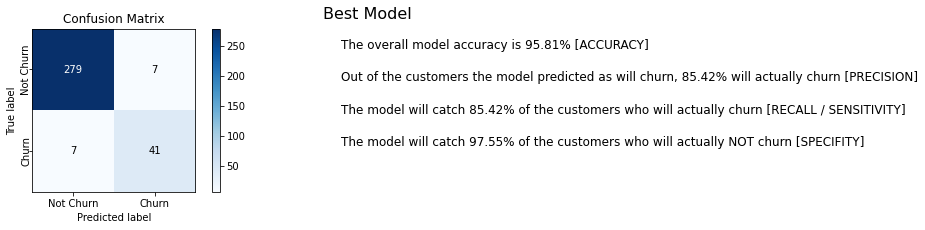

In [44]:
labels = ['Not Churn','Churn']
plot_confusion_matrix(test_target, predictions, labels, 'Best Model')